In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.applications import DenseNet121
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import models
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import cv2
import os
from skimage import exposure
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.math import confusion_matrix
from sklearn.metrics import accuracy_score
from seaborn import heatmap
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from ast import literal_eval
from matplotlib.patches import Rectangle

In [2]:
LEARNING_RATE = 1e-3
TARGET_SIZE = (224,224)
INPUT_SHAPE = (224,224,3)
EPOCHS = 60

CLASS_MODE = 'categorical'
LOSS_METRIC = 'categorical_crossentropy'

MODEL_SAVED_FILE = './weights/chexnet_mcs.hdf5'
TRAIN_IMAGE_FOLDER = '/home/TBX11K/Segmented/train'
VALIDATION_IMAGE_FOLDER = '/home/TBX11K/Segmented/val'

SEED = 42
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

#### Keras Callbacks

In [3]:
import datetime as dt
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LambdaCallback
from keras.callbacks import TensorBoard
from tensorflow.keras import backend as K


tensorboard = TensorBoard(log_dir="./logs-"+dt.datetime.now().strftime("%m%d%Y%H%M%S"),
                            histogram_freq=0,
                            write_graph=False,
                            update_freq='epoch')

def epoch_end(epoch, logs):
    message = "End of epoch "+str(epoch)+". Learning rate: "+str(K.eval(chexnet_model.optimizer.lr))
    os.system('echo '+message)

def epoch_begin(epoch, logs):
    print("Learning rate: ", K.eval(chexnet_model.optimizer.lr))
    
def train_begin(logs):
    os.system("echo Beginning training")
    


checkpoint = ModelCheckpoint(MODEL_SAVED_FILE,
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             save_weights_only=False,
                             save_freq='epoch')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta = 1e-4, 
                          patience=30,
                          verbose=1,
                          mode='min',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_loss',
                             factor=np.sqrt(.1),
                             patience=10,
                             verbose=1,
                             mode='min',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

lambdacb = LambdaCallback(on_epoch_begin=epoch_begin,
                          on_epoch_end=epoch_end,
                          on_batch_begin=None,
                          on_batch_end=None,
                          on_train_begin=train_begin,
                          on_train_end=None)

#### Image Data Generator

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from sklearn.utils import class_weight


#train data generator
train_datagen = ImageDataGenerator(
    horizontal_flip = True,
    zoom_range = 0.3,
    shear_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=10,
    brightness_range = [0.75, 1.25],
    fill_mode='nearest',
)

train_generator = train_datagen.flow_from_directory(
        TRAIN_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
        class_mode= CLASS_MODE)

#validation imagedatagenerator
test_datagen = ImageDataGenerator()
validation_generator = test_datagen.flow_from_directory(
        VALIDATION_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        seed=42,
        class_mode=CLASS_MODE)
from collections import Counter
print('train class indices:',train_generator.class_indices)
counter = Counter(train_generator.classes)

total_train = 0
num_classes = 0
for cls_idx,item in counter.items():
    total_train += item
    num_classes += 1

class_weights = {}
for cls_idx,weight in counter.items():
    cls_weight = total_train/(weight*num_classes)
    class_weights[cls_idx] = cls_weight

print('class weights:',class_weights)
print('samples for train class labels:',counter.items())
print('\n')

print('validation class indices:',validation_generator.class_indices)
counter = Counter(validation_generator.classes)
print('samples for validation class labels:',counter.items())

Found 7566 images belonging to 3 classes.
Found 1551 images belonging to 3 classes.
train class indices: {'health': 0, 'sick': 1, 'tb': 2}
class weights: {0: 0.7479240806642942, 1: 0.8135483870967742, 2: 2.3053016453382082}
samples for train class labels: dict_items([(0, 3372), (1, 3100), (2, 1094)])


validation class indices: {'health': 0, 'sick': 1, 'tb': 2}
samples for validation class labels: dict_items([(0, 702), (1, 600), (2, 249)])


### ChexNet Model Compile

In [5]:
#load pretrained efficientnet model fine-tuned on our dataset
from tensorflow import keras
base_model = keras.models.load_model('./weights/chexnet_segmented.hdf5')
chexnet_extract = base_model.layers[-3].output
chexnet_extract = Dropout(0.5)(chexnet_extract)
output = Dense(3, activation='softmax')(chexnet_extract)

for layer in base_model.layers:
    layer.trainable=False
    
chexnet_model = Model(base_model.input, output)
chexnet_model.summary()

2022-08-28 04:17:06.529777: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-08-28 04:17:06.529847: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [7]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
chexnet_model.compile(
    optimizer=adam_optimizer,
    loss= LOSS_METRIC,
    metrics=["accuracy",
             tf.keras.metrics.AUC(name='AUC'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
)
history = chexnet_model.fit(train_generator,
                            epochs=20,
                            validation_data=validation_generator,
                            verbose=1,
                            class_weight = class_weights,
                            callbacks=[reducelr, earlystop,checkpoint,lambdacb])

Beginning training
Learning rate:  0.001
Epoch 1/20
237/237 [==============================] - ETA: 0s - loss: 0.1655 - accuracy: 0.9414 - AUC: 0.9927 - precision: 0.9490 - recall: 0.9342
Epoch 00001: val_loss did not improve from 0.60571
End of epoch 0. Learning rate: 0.001
237/237 [==============================] - 106s 426ms/step - loss: 0.1655 - accuracy: 0.9414 - AUC: 0.9927 - precision: 0.9490 - recall: 0.9342 - val_loss: 0.6896 - val_accuracy: 0.7550 - val_AUC: 0.9094 - val_precision: 0.7740 - val_recall: 0.7331 - lr: 0.0010
Learning rate:  0.001
Epoch 2/20
237/237 [==============================] - ETA: 0s - loss: 0.1530 - accuracy: 0.9486 - AUC: 0.9932 - precision: 0.9527 - recall: 0.9425
Epoch 00002: val_loss did not improve from 0.60571
End of epoch 1. Learning rate: 0.001
237/237 [==============================] - 101s 426ms/step - loss: 0.1530 - accuracy: 0.9486 - AUC: 0.9932 - precision: 0.9527 - recall: 0.9425 - val_loss: 0.6079 - val_accuracy: 0.7750 - val_AUC: 0.9225 -

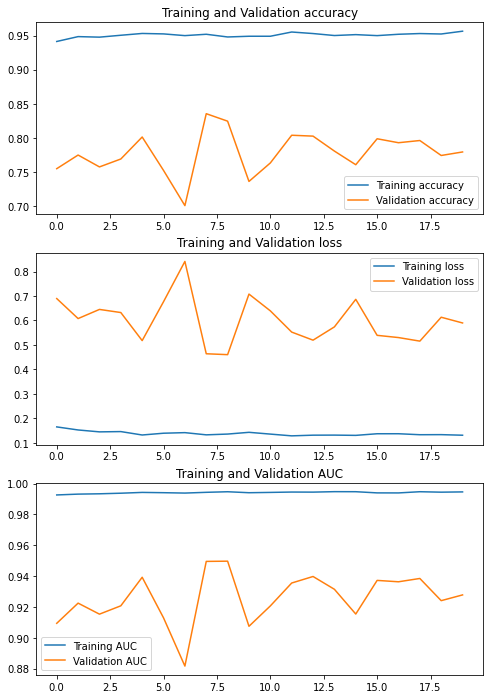

In [8]:
fig, axs = plt.subplots(3, 1, figsize=(8, 12))
plt.subplot(3, 1, 1)
plt.title('Training and Validation accuracy')
plt.plot(history.epoch, history.history['accuracy'], label='Training accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='Validation accuracy')
plt.legend()

plt.subplot(3, 1, 2)
plt.title('Training and Validation loss')
plt.plot(history.epoch, history.history['loss'], label='Training loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation loss')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Training and Validation AUC')
plt.plot(history.epoch, history.history['AUC'], label='Training AUC')
plt.plot(history.epoch, history.history['val_AUC'], label='Validation AUC')
plt.legend()

plt.show()

In [9]:
import pandas as pd
hist_df = pd.DataFrame(history.history) 
hist_df.index.name='epoch'
hist_df.sort_values(by=['val_loss'],ascending=True)

,loss,accuracy,AUC,precision,recall,val_loss,val_accuracy,val_AUC,val_precision,val_recall,lr
epoch,,,,,,,,,,,
8,0.136281,0.948057,0.994731,0.952172,0.944621,0.460544,0.824629,0.949694,0.831357,0.813669,0.001000
7,0.133126,0.952022,0.994357,0.956690,0.948850,0.464185,0.835590,0.949549,0.848930,0.818827,0.001000
17,0.133613,0.953080,0.994746,0.956609,0.949907,0.515788,0.796260,0.938479,0.802111,0.784010,0.001000
4,0.132496,0.953212,0.994298,0.957523,0.950436,0.517914,0.801418,0.939261,0.812749,0.789168,0.001000
12,0.131750,0.953080,0.994485,0.956180,0.948850,0.519704,0.802708,0.939764,0.811296,0.787234,0.001000
16,0.137622,0.952022,0.993964,0.955659,0.948586,0.530320,0.793037,0.936328,0.802387,0.780142,0.001000
15,0.137581,0.950040,0.993991,0.953148,0.946471,0.539397,0.798839,0.937225,0.805960,0.784655,0.001000
11,0.129004,0.955326,0.994533,0.959787,0.952683,0.552702,0.803997,0.935525,0.815282,0.791103,0.001000
13,0.132025,0.950172,0.994785,0.955097,0.947396,0.573921,0.780787,0.931458,0.789335,0.773050,0.001000


#### Fine-tune ChexNet

In [10]:
for layer in chexnet_model.layers:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

In [11]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
chexnet_model.compile(
    optimizer=adam_optimizer,
    loss= LOSS_METRIC,
    metrics=["accuracy",
             tf.keras.metrics.AUC(name='AUC'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
)
history_finetune = chexnet_model.fit(train_generator,
                            epochs=35,
                            validation_data=validation_generator,
                            verbose=1,
                            initial_epoch=history.epoch[-1],
                             callbacks=[reducelr, earlystop,checkpoint,lambdacb])

Beginning training
Learning rate:  1e-04
Epoch 20/35
237/237 [==============================] - ETA: 0s - loss: 0.1269 - accuracy: 0.9555 - AUC: 0.9949 - precision: 0.9575 - recall: 0.9520
Epoch 00020: val_loss improved from 0.46054 to 0.32319, saving model to ./weights/chexnet_mcs.hdf5
End of epoch 19. Learning rate: 1e-04
237/237 [==============================] - 122s 472ms/step - loss: 0.1269 - accuracy: 0.9555 - AUC: 0.9949 - precision: 0.9575 - recall: 0.9520 - val_loss: 0.3232 - val_accuracy: 0.8885 - val_AUC: 0.9727 - val_precision: 0.8957 - val_recall: 0.8801 - lr: 1.0000e-04
Learning rate:  1e-04
Epoch 21/35
237/237 [==============================] - ETA: 0s - loss: 0.0981 - accuracy: 0.9633 - AUC: 0.9966 - precision: 0.9664 - recall: 0.9622
Epoch 00021: val_loss did not improve from 0.32319
End of epoch 20. Learning rate: 1e-04
237/237 [==============================] - 108s 456ms/step - loss: 0.0981 - accuracy: 0.9633 - AUC: 0.9966 - precision: 0.9664 - recall: 0.9622 - val

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
initial_epochs=history.epoch[-1]

acc += history_finetune.history['accuracy']
val_acc += history_finetune.history['val_accuracy']
loss += history_finetune.history['loss']
val_loss += history_finetune.history['val_loss']

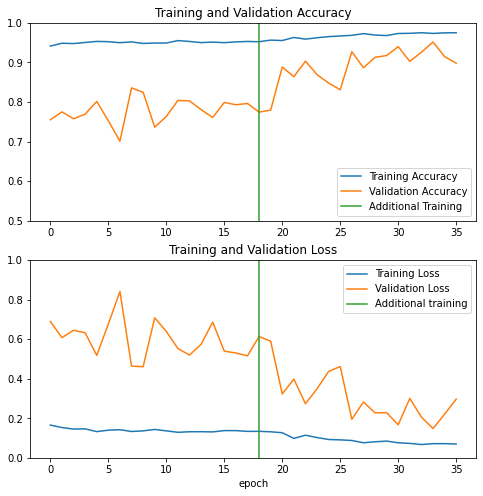

In [16]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Additional Training')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Additional training')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [13]:
hist_df = pd.DataFrame(history_finetune.history) 
hist_df.index.name='epoch'
hist_df.sort_values(by=['val_loss'],ascending=True)

,loss,accuracy,AUC,precision,recall,val_loss,val_accuracy,val_AUC,val_precision,val_recall,lr
epoch,,,,,,,,,,,
13,0.071397,0.973434,0.997967,0.974940,0.971848,0.147989,0.951644,0.993552,0.953866,0.946486,0.0001
10,0.075941,0.973302,0.998079,0.974668,0.971319,0.166746,0.940039,0.991457,0.943005,0.938749,0.0001
6,0.087626,0.968676,0.997201,0.970811,0.967090,0.194800,0.927144,0.987853,0.931258,0.925854,0.0001
12,0.067122,0.975152,0.998370,0.975884,0.973434,0.205834,0.925854,0.987827,0.935780,0.920696,0.0001
14,0.071523,0.974888,0.998050,0.977173,0.973169,0.220438,0.914894,0.986072,0.923379,0.909091,0.0001
8,0.080998,0.969337,0.997882,0.971107,0.968411,0.227431,0.912959,0.986306,0.928713,0.907157,0.0001
9,0.084509,0.968015,0.997670,0.969633,0.966429,0.228511,0.917473,0.984387,0.920440,0.917473,0.0001
2,0.114353,0.959027,0.995620,0.961840,0.956119,0.273672,0.903288,0.980297,0.912929,0.892328,0.0001
7,0.076004,0.972905,0.997951,0.974148,0.971187,0.282459,0.886525,0.979481,0.899540,0.883301,0.0001


In [17]:
history_finetune2 = chexnet_model.fit(train_generator,
                            epochs=45,
                            validation_data=validation_generator,
                            verbose=1,
                            initial_epoch=history_finetune.epoch[-1],
                             callbacks=[reducelr, earlystop,checkpoint,lambdacb])

Beginning training
Learning rate:  1e-04
Epoch 35/45
237/237 [==============================] - ETA: 0s - loss: 0.0617 - accuracy: 0.9771 - AUC: 0.9986 - precision: 0.9779 - recall: 0.9761
Epoch 00035: val_loss did not improve from 0.14799
End of epoch 34. Learning rate: 1e-04
237/237 [==============================] - 108s 454ms/step - loss: 0.0617 - accuracy: 0.9771 - AUC: 0.9986 - precision: 0.9779 - recall: 0.9761 - val_loss: 0.1759 - val_accuracy: 0.9381 - val_AUC: 0.9902 - val_precision: 0.9413 - val_recall: 0.9310 - lr: 1.0000e-04
Learning rate:  1e-04
Epoch 36/45
237/237 [==============================] - ETA: 0s - loss: 0.0670 - accuracy: 0.9765 - AUC: 0.9984 - precision: 0.9773 - recall: 0.9750
Epoch 00036: val_loss improved from 0.14799 to 0.13447, saving model to ./weights/chexnet_mcs.hdf5
End of epoch 35. Learning rate: 1e-04
237/237 [==============================] - 109s 458ms/step - loss: 0.0670 - accuracy: 0.9765 - AUC: 0.9984 - precision: 0.9773 - recall: 0.9750 - val

In [18]:
hist_df = pd.DataFrame(history_finetune2.history) 
hist_df.index.name='epoch'
hist_df.sort_values(by=['val_loss'],ascending=True)

,loss,accuracy,AUC,precision,recall,val_loss,val_accuracy,val_AUC,val_precision,val_recall,lr
epoch,,,,,,,,,,,
8,0.063882,0.976342,0.998480,0.977216,0.975020,0.111440,0.965184,0.995284,0.965784,0.964539,0.0001
10,0.060765,0.977267,0.998591,0.978154,0.976474,0.129559,0.953578,0.994745,0.956578,0.951644,0.0001
9,0.058600,0.979514,0.998626,0.980135,0.978192,0.130778,0.960671,0.993612,0.962508,0.960026,0.0001
1,0.066958,0.976474,0.998403,0.977345,0.975020,0.134471,0.957447,0.993331,0.959276,0.956802,0.0001
7,0.062199,0.976738,0.998704,0.978146,0.976077,0.173405,0.942618,0.991031,0.944912,0.940039,0.0001
6,0.062853,0.976870,0.998535,0.978137,0.975681,0.175531,0.940683,0.991275,0.943396,0.934881,0.0001
0,0.061686,0.977135,0.998593,0.977887,0.976077,0.175899,0.938104,0.990202,0.941330,0.931012,0.0001
3,0.065976,0.976077,0.998395,0.977345,0.975020,0.176208,0.941328,0.991084,0.945348,0.936815,0.0001
5,0.062542,0.976738,0.998573,0.978391,0.975416,0.176635,0.940683,0.990965,0.945822,0.934236,0.0001


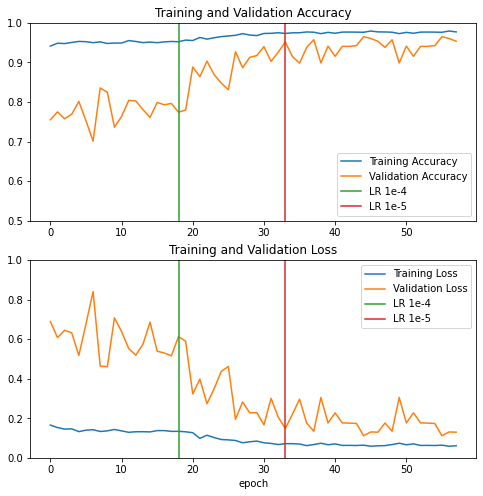

In [20]:
acc += history_finetune2.history['accuracy']
val_acc += history_finetune2.history['val_accuracy']
loss += history_finetune2.history['loss']
val_loss += history_finetune2.history['val_loss']
finetune2 =history_finetune.epoch[-1]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='LR 1e-4')

plt.plot([finetune2-1,finetune2-1],
          plt.ylim(), label='LR 1e-5')

plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='LR 1e-4')
plt.plot([finetune2-1,finetune2-1],
         plt.ylim(), label='LR 1e-5')

plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Model Evaluation

#### Montgomery County dataset

In [23]:
TEST_IMAGE_FOLDER = '/home/TBX11K/Segmented/test/Montgomery'
test_generator = test_datagen.flow_from_directory(
        TEST_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        class_mode=CLASS_MODE)

model = tf.keras.models.load_model('./weights/chexnet_mcs.hdf5')
res = model.predict(test_generator)

Found 28 images belonging to 3 classes.


In [24]:
from sklearn.metrics import classification_report
predicted = np.argmax(res, axis=1)
report = classification_report(test_generator.classes, predicted,digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.8421    1.0000    0.9143        16
           2     1.0000    0.7500    0.8571        12

    accuracy                         0.8929        28
   macro avg     0.9211    0.8750    0.8857        28
weighted avg     0.9098    0.8929    0.8898        28



#### Shenzhen Evaluation

In [25]:
TEST_IMAGE_FOLDER = '/home/TBX11K/Segmented/test/Shenzhen'
test_generator = test_datagen.flow_from_directory(
        TEST_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        class_mode=CLASS_MODE)

res = model.predict(test_generator)

Found 134 images belonging to 3 classes.


In [26]:
from sklearn.metrics import classification_report
predicted = np.argmax(res, axis=1)
report = classification_report(test_generator.classes, predicted,digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.8649    0.9697    0.9143        66
           2     0.9667    0.8529    0.9062        68

    accuracy                         0.9104       134
   macro avg     0.9158    0.9113    0.9103       134
weighted avg     0.9165    0.9104    0.9102       134

